In [1]:
# импортируем необходимые библиотеки, классы и функции
import numpy as np  
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(suppress=True)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# загружаем и смотрим данные
data = pd.read_csv('Data/bankloan.csv', sep=';', decimal=',')
data.head()

,age,job,debtinc,creddebt,othdebt,default
0,28,working - other,17.7,2.990592,4.797408,0
1,64,working - production,14.7,5.047392,12.004608,0
2,40,working - IT,4.8,1.042368,1.885632,0
3,30,working - IT,34.5,1.751220,7.563780,0
4,25,working - IT,22.4,0.759360,5.960640,1


In [3]:
# разбиваем данные на обучающие и тестовые: получаем обучающий
# массив предикторов, тестовый массив предикторов, обучающий массив
# меток, тестовый массив меток
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('default', axis=1), 
    data['default'], 
    test_size=0.3,
    stratify=data['default'],
    random_state=42)

In [4]:
# создаем копию обучающего массива предикторов
X_train_unstandardized = X_train.copy()
# выполняем дамми-кодирование, пропустив стандартизацию
X_train_unstandardized = pd.get_dummies(X_train_unstandardized)

In [5]:
# создаем список количественных переменных
num_cols = ['age', 'debtinc', 'creddebt', 'othdebt']
# создаем экземпляр класса StandardScaler
standardscaler = StandardScaler()
# выполняем стандартизацию
standardscaler.fit(X_train[num_cols])
X_train[num_cols] = standardscaler.transform(X_train[num_cols])
X_test[num_cols] = standardscaler.transform(X_test[num_cols])

In [6]:
# выполняем дамми-кодирование
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train.head()

,age,debtinc,creddebt,othdebt,job_civil service,job_own business,job_working - IT,job_working - other,job_working - production
1043,1.935771,0.966834,1.096048,-0.364248,0,0,1,0,0
337,2.166884,-0.388813,-0.187146,0.430002,0,1,0,0,0
1250,-1.222770,-1.117656,-0.593156,-0.620086,0,0,0,1,0
450,-0.914619,0.106800,-0.096743,-0.304602,1,0,0,0,0
437,-0.375356,-0.476274,-0.283492,-0.072264,0,0,0,1,0


In [7]:
# пишем собственный класс, строящий логистическую регрессию
# с помощью метода градиентного спуска без 
# ранней остановки по допуску сходимости
class LogisticRegression_GD_wo_tol:
    """
    Класс, строящий логистическую регрессию
    с помощью метода градиентного спуска без 
    ранней остановки по допуску сходимости.
    
    Параметры
    ----------
    init_method: string, по умолчанию 'zero'
        Метод инициализации весов.
        Можно выбрать 'random' или 'zero'.
    lr: float, по умолчанию 0.01
        Темп обучения.
    num_iter: int, по умолчанию 10000
        Количество итераций градиентного спуска.
    fit_intercept: bool, по умолчанию True
        Добавление константы.
    verbose: bool, по умолчанию True
        Печать результатов оптимизации.
        
    Атрибуты
    ----------
    loss_by_iter_: ndarray of shape (num_iter, )
        Список значений функции потерь по итерациям.       
    """
    def __init__(self, init_method='zero', lr=0.01, num_iter=10000,        
                 fit_intercept=True, verbose=True):

        if init_method not in ['random', 'zero']:     
            raise ValueError(
                "init_method must be one of {'random', 'zero'}, "
                "got '%s' instead" % init_method
            )
        
        # метод инициализации весов
        self.init_method = init_method    
        # темп обучения
        self.lr = lr
        # количество итераций градиентного спуска
        self.num_iter = num_iter
        # добавление константы
        self.fit_intercept = fit_intercept
        # печать результатов оптимизации
        self.verbose = verbose
        # список, в котором будем хранить значения
        # функции потерь
        self.loss_by_iter_ = []  

    # частный метод __add_intercept добавляет константу
    def __add_intercept(self, X):
        # создаем массив из единиц, количество единиц
        # равно количеству наблюдений
        intercept = np.ones((X.shape[0], 1))
        # конкатенируем массив из единиц с массивом 
        # предикторов по оси столбцов
        return np.concatenate((intercept, X), axis=1)

    # частный метод __sigmoid вычисляет значение сигмоиды
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    # частный метод __loss вычисляет значение 
    # логистической функции потерь
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    # метод .fit() выполняет обучение 
    def fit(self, X, y):
        # если задан fit_intercept=True, добавляем константу
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # инициализируем веса
        self.theta = np.zeros(X.shape[1])

        # выполняем градиентный спуск
        for i in range(self.num_iter):
            # вычисляем скалярное произведение 
            # матрицы предикторов и вектора весов
            z = np.dot(X, self.theta)
            # к полученному результату применяем сигмоиду, по сути
            # получаем вероятности положительного класса
            h = self.__sigmoid(z)
            
            # получаем вектор градиента, для этого делим 
            # скалярное произведение транспонированной 
            # матрицы предикторов и вектора разностей между 
            # вероятностями и фактическими значениями зависимой 
            # переменной на количество наблюдений
            gradient = np.dot(X.T, (h - y)) / y.size
            # обновляем веса, вычитаем из текущего приближения 
            # вектора весов вектор градиента, умноженный 
            # на некоторый темп обучения
            self.theta -= self.lr * gradient

            # если задано verbose=True, то вычисляем значение функции
            # потерь и добавляем значение функции потерь в список для
            # отрисовки с помощью метода .loss_visualize(), затем
            # печатаем номер итерации, значение функции потерь и веса                   
            if self.verbose:
                loss = self.__loss(h, y)
                self.loss_by_iter_.append(loss)
                print(f"Итерация: {i}\n", 
                      f"Функция потерь: {round(loss, 3)}\n", 
                      f"Коэфф-ты: {np.round(self.theta, 3)}")

    # метод .loss_visualize() отрисовывает 
    # кривую функции потерь
    def loss_visualize(self):  
        plt.plot(range(len(self.loss_by_iter_)), self.loss_by_iter_)
        plt.xticks(np.arange(0, self.num_iter, step=self.num_iter / 5))
        plt.xlabel("Количество итераций")
        plt.ylabel("Логистическая функция потерь")
        plt.show()
                
    # метод .predict_proba() вычисляет вероятности
    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))
    
    # метод .predict() вычисляет прогнозы
    def predict(self, X, threshold):
        return (self.predict_proba(X) >= threshold).astype(int)

Итерация: 0
 Функция потерь: 0.693
 Коэфф-ты: [-0.007 -0.316 -0.003  0.002 -0.013 -0.    -0.001 -0.002 -0.003 -0.   ]
Итерация: 1
 Функция потерь: 3.396
 Коэфф-ты: [0.012 0.214 0.242 0.053 0.074 0.004 0.003 0.    0.003 0.   ]
Итерация: 2
 Функция потерь: 6.425
 Коэфф-ты: [-0.02  -0.948 -0.01   0.005 -0.039 -0.001 -0.004 -0.006 -0.008 -0.001]
Итерация: 3
 Функция потерь: 10.182
 Коэфф-ты: [-0.002 -0.418  0.236  0.056  0.048  0.004  0.001 -0.004 -0.002 -0.   ]
Итерация: 4
 Функция потерь: 3.138
 Коэфф-ты: [ 0.016  0.108  0.476  0.107  0.133  0.009  0.005 -0.002  0.004  0.   ]
Итерация: 5
 Функция потерь: 5.344
 Коэфф-ты: [-0.015 -1.05   0.224  0.059  0.021  0.003 -0.002 -0.008 -0.008 -0.001]
Итерация: 6
 Функция потерь: 9.952
 Коэфф-ты: [ 0.003 -0.519  0.47   0.11   0.108  0.008  0.003 -0.006 -0.002 -0.   ]
Итерация: 7
 Функция потерь: 2.979
 Коэфф-ты: [ 0.02  -0.026  0.675  0.157  0.184  0.012  0.007 -0.004  0.004  0.   ]
Итерация: 8
 Функция потерь: 3.468
 Коэфф-ты: [-0.009 -1.075  0.4

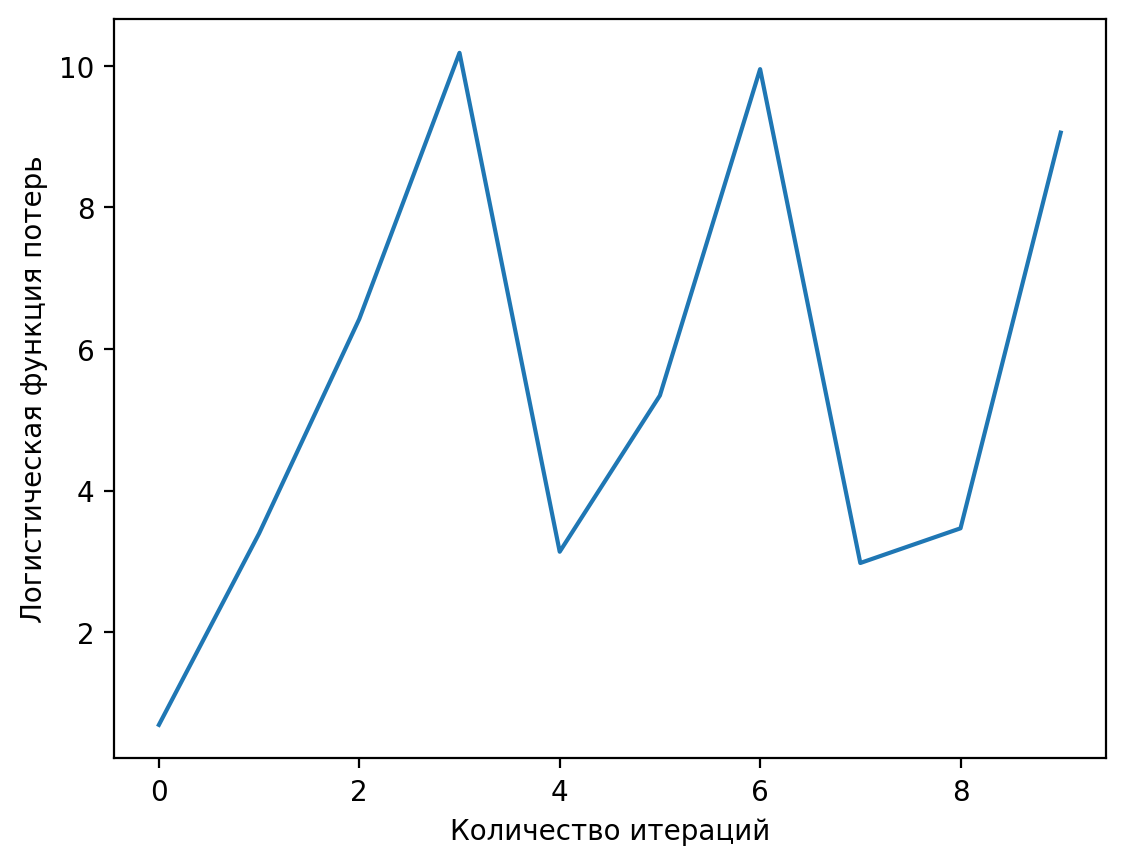

In [8]:
# создаем экземпляр нашего класса 
# LogisticRegression_GD_wo_tol
model = LogisticRegression_GD_wo_tol(
    init_method='zero', lr=0.05, num_iter=10)
# обучаем модель логистической регрессии
model.fit(X_train_unstandardized, y_train)
# визуализируем кривую функции потерь
model.loss_visualize()

Итерация: 0
 Функция потерь: 0.693
 Коэфф-ты: [-0.007 -0.007  0.009  0.005  0.002 -0.    -0.001 -0.002 -0.003 -0.   ]
Итерация: 1
 Функция потерь: 0.689
 Коэфф-ты: [-0.013 -0.014  0.018  0.009  0.005 -0.001 -0.003 -0.004 -0.005 -0.001]
Итерация: 2
 Функция потерь: 0.685
 Коэфф-ты: [-0.02  -0.02   0.027  0.014  0.007 -0.001 -0.004 -0.006 -0.008 -0.001]
Итерация: 3
 Функция потерь: 0.681
 Коэфф-ты: [-0.026 -0.027  0.036  0.018  0.009 -0.001 -0.005 -0.008 -0.01  -0.002]
Итерация: 4
 Функция потерь: 0.677
 Коэфф-ты: [-0.033 -0.034  0.045  0.023  0.011 -0.001 -0.006 -0.01  -0.013 -0.002]
Итерация: 5
 Функция потерь: 0.673
 Коэфф-ты: [-0.039 -0.04   0.053  0.027  0.013 -0.002 -0.007 -0.012 -0.015 -0.003]
Итерация: 6
 Функция потерь: 0.669
 Коэфф-ты: [-0.045 -0.047  0.062  0.031  0.015 -0.002 -0.008 -0.014 -0.018 -0.003]
Итерация: 7
 Функция потерь: 0.665
 Коэфф-ты: [-0.051 -0.053  0.07   0.035  0.016 -0.002 -0.01  -0.015 -0.02  -0.004]
Итерация: 8
 Функция потерь: 0.662
 Коэфф-ты: [-0.057 -0

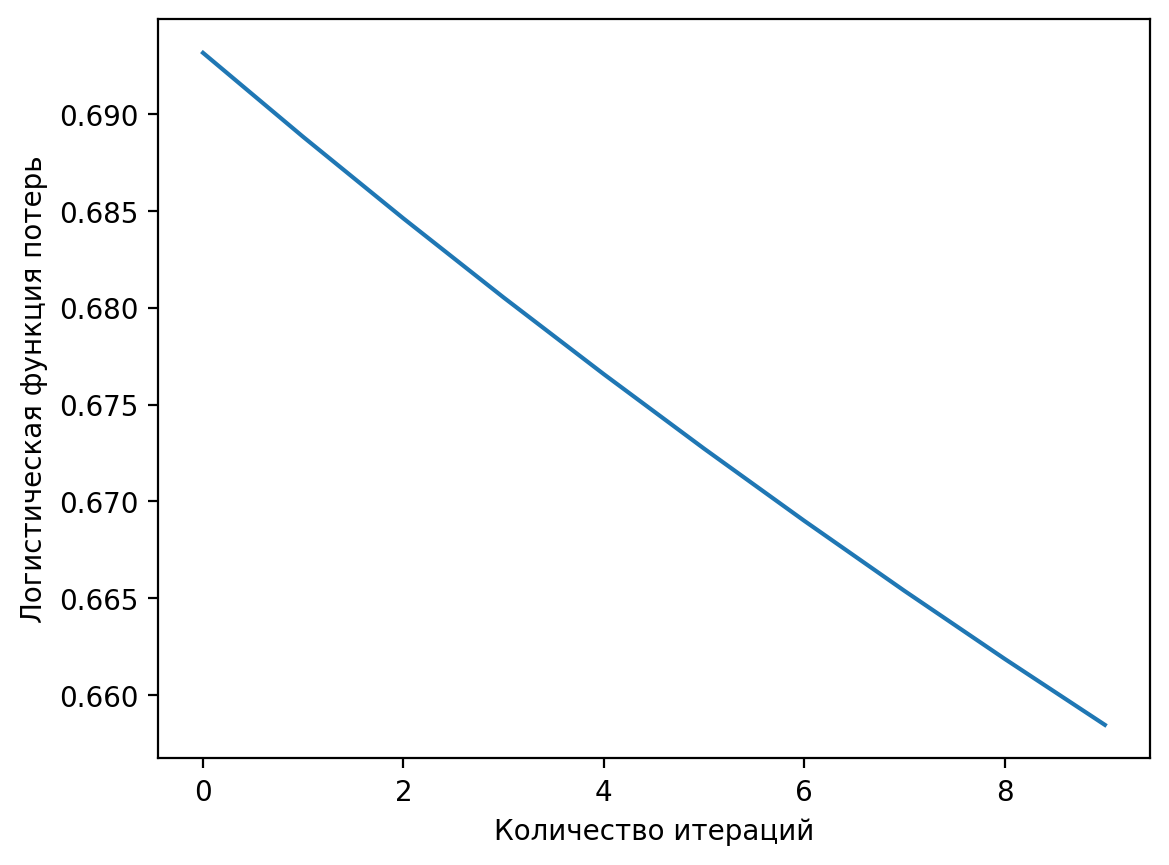

In [9]:
# создаем экземпляр нашего класса 
# LogisticRegression_GD_wo_tol
model = LogisticRegression_GD_wo_tol(
    init_method='zero', lr=0.05, num_iter=10)
# обучаем модель логистической регрессии
model.fit(X_train, y_train)
# визуализируем кривую функции потерь
model.loss_visualize()

Итерация: 0
 Функция потерь: 0.693
 Коэфф-ты: [-0.013 -0.014  0.019  0.009  0.005 -0.001 -0.003 -0.004 -0.005 -0.001]
Итерация: 1
 Функция потерь: 0.685
 Коэфф-ты: [-0.026 -0.027  0.036  0.018  0.009 -0.001 -0.005 -0.008 -0.011 -0.002]
Итерация: 2
 Функция потерь: 0.676
 Коэфф-ты: [-0.039 -0.04   0.054  0.027  0.013 -0.002 -0.007 -0.012 -0.016 -0.003]
Итерация: 3
 Функция потерь: 0.669
 Коэфф-ты: [-0.051 -0.053  0.071  0.035  0.017 -0.002 -0.01  -0.015 -0.02  -0.004]
Итерация: 4
 Функция потерь: 0.662
 Коэфф-ты: [-0.063 -0.066  0.087  0.043  0.02  -0.002 -0.012 -0.019 -0.025 -0.005]
Итерация: 5
 Функция потерь: 0.655
 Коэфф-ты: [-0.075 -0.079  0.102  0.051  0.023 -0.003 -0.014 -0.023 -0.03  -0.006]
Итерация: 6
 Функция потерь: 0.649
 Коэфф-ты: [-0.086 -0.091  0.118  0.059  0.026 -0.003 -0.016 -0.026 -0.034 -0.007]
Итерация: 7
 Функция потерь: 0.643
 Коэфф-ты: [-0.096 -0.104  0.132  0.066  0.029 -0.003 -0.018 -0.03  -0.038 -0.007]
Итерация: 8
 Функция потерь: 0.637
 Коэфф-ты: [-0.107 -0

Итерация: 223
 Функция потерь: 0.499
 Коэфф-ты: [-0.564 -0.963  0.792  0.549 -0.103  0.174 -0.104 -0.312 -0.265 -0.057]
Итерация: 224
 Функция потерь: 0.499
 Коэфф-ты: [-0.564 -0.965  0.792  0.55  -0.104  0.175 -0.104 -0.313 -0.265 -0.057]
Итерация: 225
 Функция потерь: 0.499
 Коэфф-ты: [-0.565 -0.966  0.793  0.551 -0.104  0.176 -0.104 -0.313 -0.266 -0.057]
Итерация: 226
 Функция потерь: 0.499
 Коэфф-ты: [-0.565 -0.967  0.793  0.553 -0.105  0.176 -0.104 -0.314 -0.266 -0.057]
Итерация: 227
 Функция потерь: 0.499
 Коэфф-ты: [-0.565 -0.968  0.794  0.554 -0.105  0.177 -0.104 -0.315 -0.266 -0.057]
Итерация: 228
 Функция потерь: 0.498
 Коэфф-ты: [-0.566 -0.969  0.794  0.555 -0.106  0.178 -0.105 -0.315 -0.267 -0.057]
Итерация: 229
 Функция потерь: 0.498
 Коэфф-ты: [-0.566 -0.971  0.795  0.556 -0.107  0.179 -0.105 -0.316 -0.267 -0.057]
Итерация: 230
 Функция потерь: 0.498
 Коэфф-ты: [-0.566 -0.972  0.795  0.557 -0.107  0.179 -0.105 -0.317 -0.267 -0.057]
Итерация: 231
 Функция потерь: 0.498
 Ко

Итерация: 447
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.109  0.84   0.726 -0.206  0.304 -0.12  -0.42  -0.312 -0.062]
Итерация: 448
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.11   0.84   0.727 -0.207  0.305 -0.12  -0.42  -0.312 -0.062]
Итерация: 449
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.11   0.84   0.727 -0.207  0.305 -0.12  -0.42  -0.312 -0.062]
Итерация: 450
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.11   0.84   0.728 -0.207  0.305 -0.12  -0.421 -0.313 -0.062]
Итерация: 451
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.111  0.84   0.728 -0.208  0.306 -0.12  -0.421 -0.313 -0.062]
Итерация: 452
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.111  0.84   0.729 -0.208  0.306 -0.121 -0.421 -0.313 -0.062]
Итерация: 453
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.111  0.84   0.729 -0.208  0.307 -0.121 -0.422 -0.313 -0.062]
Итерация: 454
 Функция потерь: 0.494
 Коэфф-ты: [-0.611 -1.111  0.841  0.73  -0.209  0.307 -0.121 -0.422 -0.313 -0.062]
Итерация: 455
 Функция потерь: 0.494
 Ко

Итерация: 700
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.857  0.814 -0.267  0.377 -0.129 -0.481 -0.33  -0.062]
Итерация: 701
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.857  0.814 -0.267  0.377 -0.13  -0.482 -0.33  -0.062]
Итерация: 702
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.857  0.814 -0.268  0.377 -0.13  -0.482 -0.33  -0.062]
Итерация: 703
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.857  0.814 -0.268  0.377 -0.13  -0.482 -0.33  -0.062]
Итерация: 704
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.858  0.814 -0.268  0.377 -0.13  -0.482 -0.33  -0.062]
Итерация: 705
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.858  0.815 -0.268  0.378 -0.13  -0.482 -0.33  -0.062]
Итерация: 706
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.858  0.815 -0.268  0.378 -0.13  -0.482 -0.33  -0.062]
Итерация: 707
 Функция потерь: 0.493
 Коэфф-ты: [-0.626 -1.156  0.858  0.815 -0.268  0.378 -0.13  -0.483 -0.33  -0.062]
Итерация: 708
 Функция потерь: 0.493
 Ко

Итерация: 948
 Функция потерь: 0.493
 Коэфф-ты: [-0.631 -1.17   0.867  0.851 -0.298  0.41  -0.134 -0.513 -0.335 -0.06 ]
Итерация: 949
 Функция потерь: 0.493
 Коэфф-ты: [-0.631 -1.17   0.867  0.851 -0.298  0.41  -0.134 -0.513 -0.335 -0.06 ]
Итерация: 950
 Функция потерь: 0.493
 Коэфф-ты: [-0.632 -1.17   0.867  0.852 -0.298  0.41  -0.134 -0.513 -0.335 -0.06 ]
Итерация: 951
 Функция потерь: 0.493
 Коэфф-ты: [-0.632 -1.17   0.867  0.852 -0.298  0.41  -0.134 -0.514 -0.335 -0.06 ]
Итерация: 952
 Функция потерь: 0.493
 Коэфф-ты: [-0.632 -1.171  0.867  0.852 -0.298  0.411 -0.134 -0.514 -0.335 -0.06 ]
Итерация: 953
 Функция потерь: 0.493
 Коэфф-ты: [-0.632 -1.171  0.867  0.852 -0.298  0.411 -0.134 -0.514 -0.335 -0.06 ]
Итерация: 954
 Функция потерь: 0.493
 Коэфф-ты: [-0.632 -1.171  0.867  0.852 -0.298  0.411 -0.134 -0.514 -0.335 -0.06 ]
Итерация: 955
 Функция потерь: 0.493
 Коэфф-ты: [-0.632 -1.171  0.867  0.852 -0.298  0.411 -0.134 -0.514 -0.335 -0.06 ]
Итерация: 956
 Функция потерь: 0.493
 Ко

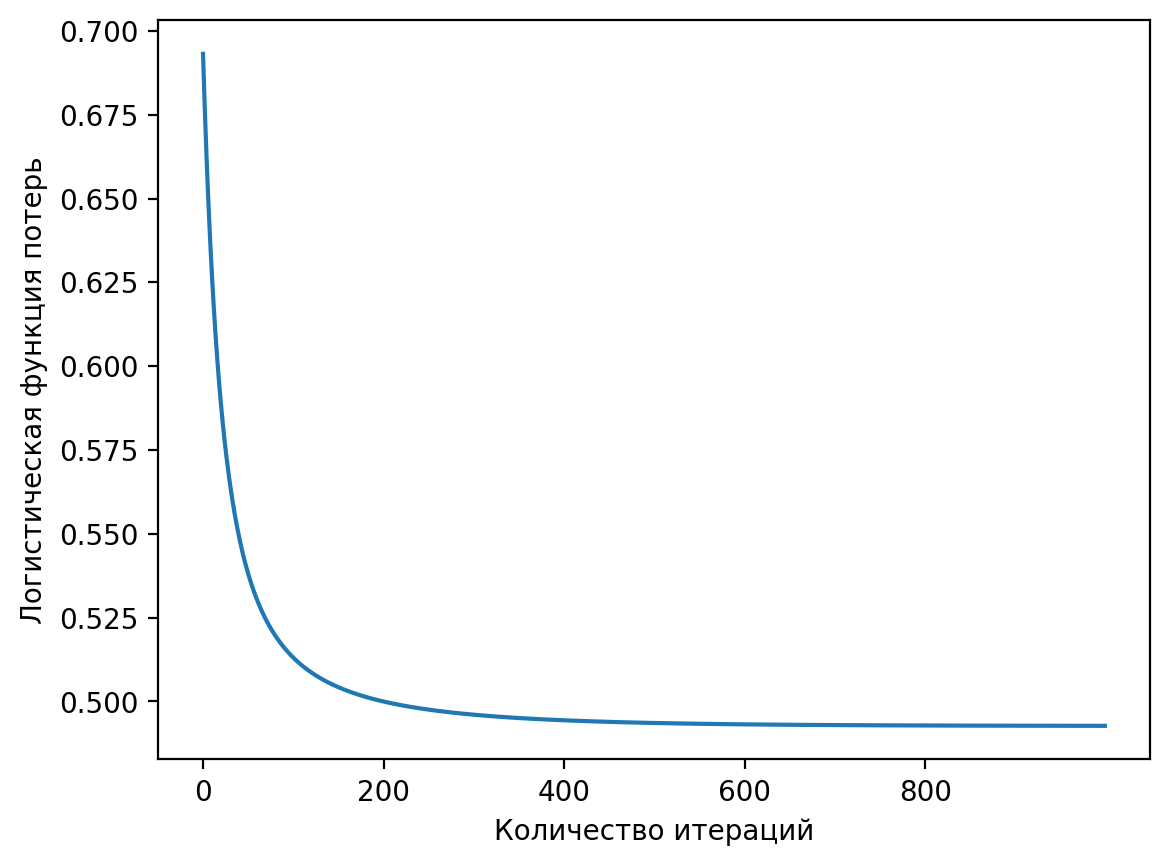

CPU times: user 6.1 s, sys: 1.59 s, total: 7.68 s
Wall time: 1.01 s


In [10]:
%%time

# создаем экземпляр нашего класса 
# LogisticRegression_GD_wo_tol
model = LogisticRegression_GD_wo_tol(
    lr=0.1, num_iter=1000, verbose=True)
# обучаем модель логистической регрессии
model.fit(X_train, y_train)
# визуализируем кривую функции потерь
model.loss_visualize()

In [11]:
# вычислим AUC-ROC
proba = model.predict_proba(X_test)
print("AUC-ROC на тестовой выборке: %.3f" % roc_auc_score(y_test, proba))

AUC-ROC на тестовой выборке: 0.787


In [12]:
# пишем собственный класс, строящий логистическую регрессию
# с помощью метода градиентного спуска с 
# ранней остановкой по допуску сходимости
class LogisticRegression_GD_w_tol:
    """
    Класс, строящий логистическую регрессию
    с помощью метода градиентного спуска с 
    ранней остановкой по допуску сходимости.
    
    Параметры
    ----------
    init_method: string, по умолчанию 'zero'
        Метод инициализации весов.
        Можно выбрать 'random' или 'zero'.
    lr: float, по умолчанию 0.01
        Темп обучения.
    tol: float, по умолчанию 1e-5
        Допуск сходимости.
    num_iter: int, по умолчанию 10000
        Количество итераций градиентного спуска.
    fit_intercept: bool, по умолчанию True
        Добавление константы.
    verbose: bool, по умолчанию True
        Печать результатов оптимизации.
        
    Атрибуты
    ----------
    loss_by_iter_: ndarray of shape (num_iter, )
        Список значений функции потерь по итерациям.       
    """
    def __init__(self, init_method='zero', lr=0.01, 
                 tol=1e-5, num_iter=10000,        
                 fit_intercept=True, verbose=True):

        if init_method not in ['random', 'zero']:     
            raise ValueError(
                "init_method must be one of {'random', 'zero'}, "
                "got '%s' instead" % init_method
            )
        
        # метод инициализации весов
        self.init_method = init_method    
        # темп обучения
        self.lr = lr
        # допуск сходимости
        self.tol = tol
        # количество итераций градиентного спуска
        self.num_iter = num_iter
        # добавление константы
        self.fit_intercept = fit_intercept
        # печать результатов оптимизации
        self.verbose = verbose
        # список, в котором будем хранить значения
        # функции потерь
        self.loss_by_iter_ = []  

    # частный метод __add_intercept добавляет константу
    def __add_intercept(self, X):
        # создаем массив из единиц, количество единиц
        # равно количеству наблюдений
        intercept = np.ones((X.shape[0], 1))
        # конкатенируем массив из единиц с массивом 
        # признаков по оси столбцов
        return np.concatenate((intercept, X), axis=1)

    # частный метод __sigmoid вычисляет значение сигмоиды
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    # частный метод __loss вычисляет значение 
    # логистической функции потерь
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    # метод .fit() выполняет обучение 
    def fit(self, X, y):
        # если задан fit_intercept=True, добавляем константу
        if self.fit_intercept:
            X = self.__add_intercept(X)
            
        # инициализируем значение функции потерь на предыдущей
        # итерации бесконечно большим значением
        l_prev = np.inf

        # инициализируем веса
        self.theta = np.zeros(X.shape[1])

        # выполняем градиентный спуск
        for i in range(self.num_iter):
            # вычисляем скалярное произведение 
            # матрицы предикторов и вектора весов
            z = np.dot(X, self.theta)
            # к полученному результату применяем сигмоиду, по сути
            # получаем вероятности положительного класса
            h = self.__sigmoid(z)
            
            # вычисляем значение функции потерь
            loss = self.__loss(h, y)
            # добавляем значение функции потерь в список
            self.loss_by_iter_.append(loss)
            
            # если разница между предыдущим значением и
            # текущим значением функции потерь меньше 
            # заданного порога (tol), то прерываем цикл, 
            # т.е. реализована ранняя остановка, которая 
            # ограничивает количество итераций (num_iter)
            if l_prev - loss < self.tol:
                return
            # присваиваем функции потерь на предыдущей
            # итерации текущее значение
            l_prev = loss
            
            # получаем вектор градиента, для этого делим 
            # скалярное произведение транспонированной 
            # матрицы предикторов и вектора разностей между 
            # вероятностями и фактическими значениями зависимой 
            # переменной на количество наблюдений
            gradient = np.dot(X.T, (h - y)) / y.size
            # обновляем веса, вычитаем из текущего приближения 
            # вектора весов вектор градиента, умноженный 
            # на некоторый темп обучения
            self.theta -= self.lr * gradient

            # если задано verbose=True, печатаем номер
            # итерации, значение функции потерь и веса                   
            if self.verbose:
                print(f"Итерация: {i}\n", 
                      f"Функция потерь: {round(loss, 3)}\n", 
                      f"Коэфф-ты: {np.round(self.theta, 3)}")

    # метод .loss_visualize() отрисовывает 
    # кривую функции потерь
    def loss_visualize(self):  
        plt.plot(range(len(self.loss_by_iter_)), self.loss_by_iter_)
        plt.xticks(np.arange(0, self.num_iter, step=self.num_iter / 5))
        plt.xlabel("Количество итераций")
        plt.ylabel("Логистическая функция потерь")
        plt.show()

    # метод .predict_proba() вычисляет вероятности
    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))
    
    # метод .predict() вычисляет прогнозы
    def predict(self, X, threshold):
        return (self.predict_proba(X) >= threshold).astype(int)

Итерация: 0
 Функция потерь: 0.693
 Коэфф-ты: [-0.007 -0.316 -0.003  0.002 -0.013 -0.    -0.001 -0.002 -0.003 -0.   ]


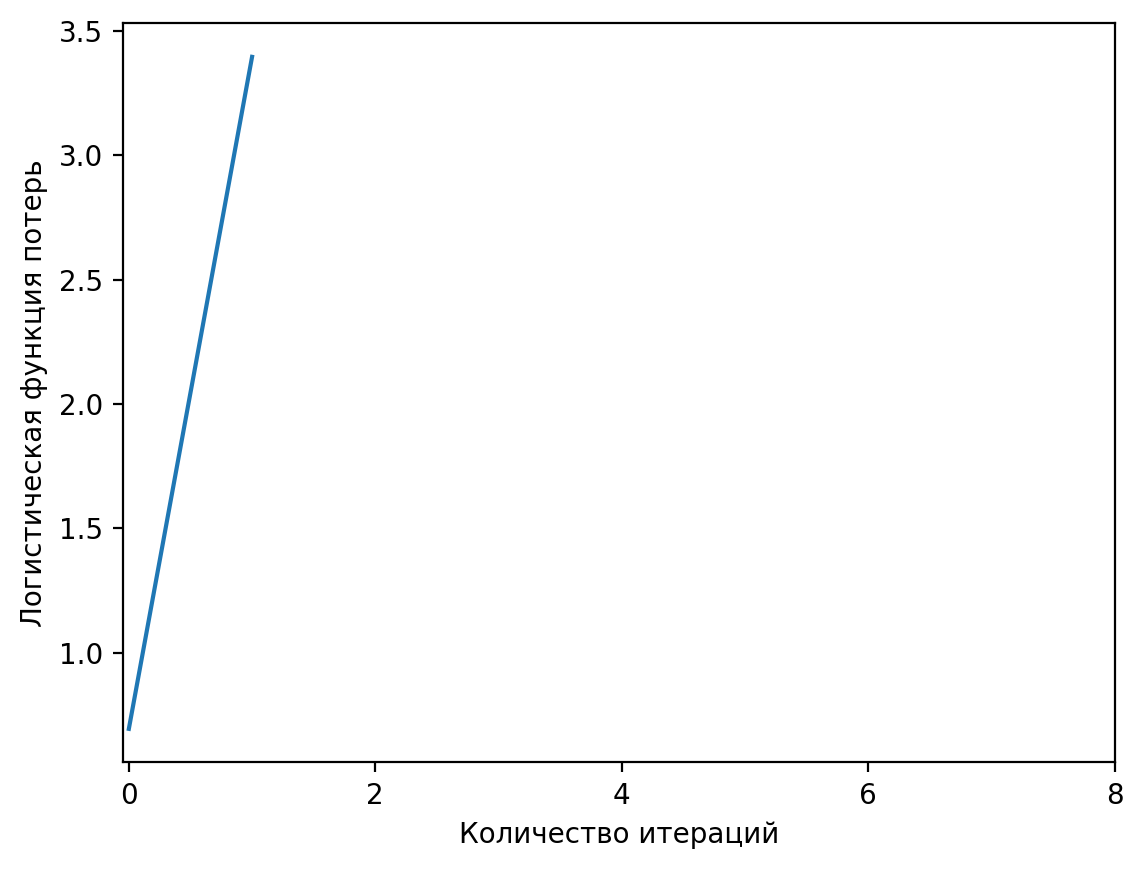

In [13]:
# создаем экземпляр нашего класса 
# LogisticRegression_GD_w_tol
model = LogisticRegression_GD_w_tol(
    init_method='zero', lr=0.05, num_iter=10)
# обучаем модель логистической регрессии
model.fit(X_train_unstandardized, y_train)
# визуализируем кривую функции потерь
model.loss_visualize()

Итерация: 0
 Функция потерь: 0.693
 Коэфф-ты: [-0.013 -0.014  0.019  0.009  0.005 -0.001 -0.003 -0.004 -0.005 -0.001]
Итерация: 1
 Функция потерь: 0.685
 Коэфф-ты: [-0.026 -0.027  0.036  0.018  0.009 -0.001 -0.005 -0.008 -0.011 -0.002]
Итерация: 2
 Функция потерь: 0.676
 Коэфф-ты: [-0.039 -0.04   0.054  0.027  0.013 -0.002 -0.007 -0.012 -0.016 -0.003]
Итерация: 3
 Функция потерь: 0.669
 Коэфф-ты: [-0.051 -0.053  0.071  0.035  0.017 -0.002 -0.01  -0.015 -0.02  -0.004]
Итерация: 4
 Функция потерь: 0.662
 Коэфф-ты: [-0.063 -0.066  0.087  0.043  0.02  -0.002 -0.012 -0.019 -0.025 -0.005]
Итерация: 5
 Функция потерь: 0.655
 Коэфф-ты: [-0.075 -0.079  0.102  0.051  0.023 -0.003 -0.014 -0.023 -0.03  -0.006]
Итерация: 6
 Функция потерь: 0.649
 Коэфф-ты: [-0.086 -0.091  0.118  0.059  0.026 -0.003 -0.016 -0.026 -0.034 -0.007]
Итерация: 7
 Функция потерь: 0.643
 Коэфф-ты: [-0.096 -0.104  0.132  0.066  0.029 -0.003 -0.018 -0.03  -0.038 -0.007]
Итерация: 8
 Функция потерь: 0.637
 Коэфф-ты: [-0.107 -0

Итерация: 237
 Функция потерь: 0.498
 Коэфф-ты: [-0.569 -0.98   0.798  0.565 -0.112  0.185 -0.105 -0.321 -0.27  -0.058]
Итерация: 238
 Функция потерь: 0.498
 Коэфф-ты: [-0.569 -0.981  0.798  0.566 -0.112  0.186 -0.106 -0.322 -0.27  -0.058]
Итерация: 239
 Функция потерь: 0.498
 Коэфф-ты: [-0.57  -0.982  0.799  0.567 -0.113  0.186 -0.106 -0.322 -0.27  -0.058]
Итерация: 240
 Функция потерь: 0.498
 Коэфф-ты: [-0.57  -0.983  0.799  0.568 -0.113  0.187 -0.106 -0.323 -0.271 -0.058]
Итерация: 241
 Функция потерь: 0.498
 Коэфф-ты: [-0.57  -0.984  0.8    0.569 -0.114  0.188 -0.106 -0.324 -0.271 -0.058]
Итерация: 242
 Функция потерь: 0.498
 Коэфф-ты: [-0.571 -0.985  0.8    0.57  -0.115  0.189 -0.106 -0.324 -0.271 -0.058]
Итерация: 243
 Функция потерь: 0.498
 Коэфф-ты: [-0.571 -0.986  0.8    0.572 -0.115  0.189 -0.106 -0.325 -0.272 -0.058]
Итерация: 244
 Функция потерь: 0.498
 Коэфф-ты: [-0.572 -0.987  0.801  0.573 -0.116  0.19  -0.106 -0.326 -0.272 -0.058]
Итерация: 245
 Функция потерь: 0.498
 Ко

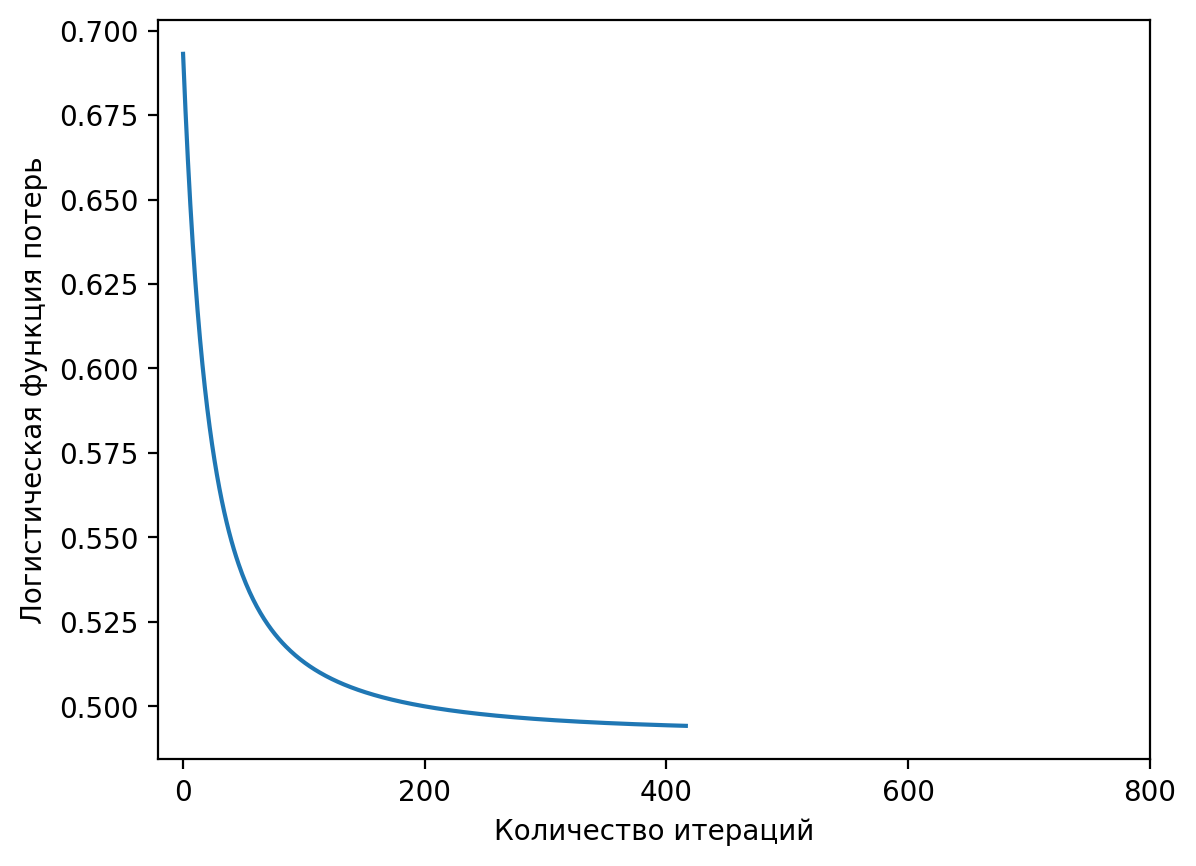

CPU times: user 2.89 s, sys: 904 ms, total: 3.8 s
Wall time: 521 ms


In [14]:
%%time

# создаем экземпляр нашего класса 
# LogisticRegression_GD_w_tol
model = LogisticRegression_GD_w_tol(
    lr=0.1, num_iter=1000, verbose=True)

# обучаем модель логистической регрессии
model.fit(X_train, y_train)
# визуализируем кривую функции потерь
model.loss_visualize()

In [15]:
# вычислим AUC-ROC
proba = model.predict_proba(X_test)
print("AUC-ROC на тестовой выборке: %.3f" % roc_auc_score(y_test, proba))

AUC-ROC на тестовой выборке: 0.788


In [16]:
# создаем игрушечный массив предикторов
X_toy = np.array([[0.1, 0.2, 0.3], 
                  [0.7, 0.5, 0.2],
                  [0.2, 0.4, 1.4],
                  [0.4, 0.1, 0.5]])

# создаем игрушечный массив значений
# зависимой переменной
y_toy = np.array([0, 1, 0, 0])

In [17]:
# создаем вектор весов, инициализируем веса очень 
# небольшими положительными значениями, близкими к 0
theta = np.array([0.01, 0.012, 0.015])

In [18]:
# вычисляем скалярное произведение 
# матрицы предикторов и вектора весов
z = np.dot(X_toy, theta)
z

array([0.0079, 0.016 , 0.0278, 0.0127])

In [19]:
# взглянем, как происходит подсчет
print((0.1 * 0.01) + (0.2 * 0.012) + (0.3 * 0.015))
print((0.7 * 0.01) + (0.5 * 0.012) + (0.2 * 0.015))
print((0.2 * 0.01) + (0.4 * 0.012) + (1.4 * 0.015))
print((0.4 * 0.01) + (0.1 * 0.012) + (0.5 * 0.015))

0.0079
0.016
0.0278
0.0127


In [20]:
# пишем функцию сигмоид-преобразования
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [21]:
# к скалярному произведению применяем сигмоид-преобразование,
# получаем вероятности положительного класса
h = sigmoid(z)
h

array([0.50197499, 0.50399991, 0.50694955, 0.50317496])

In [22]:
# пишем функцию, вычисляющую 
# логистическую функцию потерь
def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [23]:
# вычисляем логистическую функцию потерь
# на текущей итерации
loss(h, y_toy)

0.6972363215329986

In [24]:
# получаем вектор градиента, для этого делим скалярное произведение 
# транспонированной матрицы предикторов и вектора разностей между 
# вероятностями положительного класса и фактическими 
# значениями зависимой переменной на количество наблюдений
gradient = np.dot(X_toy.T, (h - y_toy)) / y_toy.size
gradient

array([0.00141433, 0.02637307, 0.25317733])

In [25]:
# смотрим транспонированную матрицу предикторов
X_toy.T

array([[0.1, 0.7, 0.2, 0.4],
       [0.2, 0.5, 0.4, 0.1],
       [0.3, 0.2, 1.4, 0.5]])

In [26]:
# смотрим вектор разностей между вероятностями
# положительного класса и фактическими
# значениями зависимой переменной
h - y_toy

array([ 0.50197499, -0.49600009,  0.50694955,  0.50317496])

In [27]:
# смотрим скалярное произведение транспонированного 
# массива предикторов и вектора разностей между 
# вероятностями положительного класса и фактическими
# значениями зависимой переменной
np.dot(X_toy.T, (h - y_toy))

array([0.00565733, 0.10549227, 1.01270933])

In [28]:
# делим скалярное произведение на количество наблюдений
np.dot(X_toy.T, (h - y_toy)) / y_toy.size

array([0.00141433, 0.02637307, 0.25317733])

In [29]:
# задаем темп обучения
lr = 0.5
# обновляем веса, вычитаем из текущего приближения 
# вектора весов вектор градиента, умноженный
# на некоторый темп обучения
theta = theta - lr * gradient
theta

array([ 0.00929283, -0.00118653, -0.11158867])

In [30]:
# пишем собственный класс, строящий логистическую 
# регрессию с помощью метода Ньютона
class LogisticRegression_Newton:
    """
    Класс, строящий логистическую регрессию
    с помощью метода Ньютона.
    
    Параметры
    ----------
    init_method: string, по умолчанию 'zero'
        Метод инициализации весов.
        Можно выбрать 'random' или 'zero'.
    num_iter: int, по умолчанию 5
        Количество итераций ньютоновской оптимизации.
    fit_intercept: bool, по умолчанию True
        Добавление константы.
    verbose: bool, по умолчанию True
        Печать результатов оптимизации.
        
    Атрибуты
    ----------
    loss_by_iter_: ndarray of shape (num_iter, )
        Список значений функции потерь по итерациям.       
    """
    def __init__(self, init_method='zero', num_iter=5, 
                 fit_intercept=True, verbose=True):
        
        if init_method not in ['random', 'zero']:     
            raise ValueError(
                "init_method must be one of {'random', 'zero'}, "
                "got '%s' instead" % init_method
            )

        # количество итераций ньютоновской оптимизации
        self.num_iter = num_iter
        # добавление константы
        self.fit_intercept = fit_intercept
        # печать результатов оптимизации
        self.verbose = verbose
        # список, в котором будем хранить значения
        # функции потерь
        self.loss_by_iter_ = []
    
    # частный метод __add_intercept добавляет константу
    def __add_intercept(self, X):
        # создаем массив из единиц, количество единиц
        # равно количеству наблюдений
        intercept = np.ones((X.shape[0], 1))
        # конкатенируем массив из единиц с массивом 
        # предикторов по оси столбцов
        return np.concatenate((intercept, X), axis=1)
    
    # частный метод __sigmoid вычисляет значение сигмоиды
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # частный метод __get_loss вычисляет значение 
    # логистической функции потерь
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    # метод .fit() выполняет обучение
    def fit(self, X, y):
        # если задан fit_intercept=True, добавляем константу
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # инициализируем веса признаков нулями
        self.theta = np.zeros(X.shape[1])
        
        # выполняем ньютоновскую оптимизацию
        for i in range(self.num_iter):
            # вычисляем скалярное произведение 
            # матрицы предикторов и вектора весов
            z = np.dot(X, self.theta)
            # к полученному результату применяем сигмоиду, по сути
            # получаем вероятности положительного класса
            h = self.__sigmoid(z) 
            
            # вычисляем градиент
            grad = np.dot(h - y, X)
            # вычисляем гессиан
            X_ = (h * (1 - h))[:, np.newaxis] * X
            hess = np.dot(X_.T, X)
            # получаем обратный гессиан
            inv_hess = np.linalg.pinv(hess)
            # умножаем градиент на обратный гессиан
            grad = np.dot(inv_hess, grad)
            # выполняем обновление весов
            self.theta -= grad

            # если задано verbose=True, то вычисляем значение функции
            # потерь и добавляем значение функции потерь в список для
            # отрисовки с помощью метода .loss_visualize(), затем
            # печатаем номер итерации, значение функции потерь и веса
            if self.verbose:
                loss = self.__loss(h, y)
                self.loss_by_iter_.append(loss)
                print(f"Итерация: {i}\n", 
                      f"Функция потерь: {round(loss, 3)}\n", 
                      f"Коэфф-ты: {np.round(self.theta, 3)}")
         
    # метод .loss_visualize() отрисовывает 
    # кривую функции потерь
    def loss_visualize(self):  
        plt.plot(range(len(self.loss_by_iter_)), self.loss_by_iter_)
        plt.xticks(np.arange(0, self.num_iter, step=self.num_iter / 5))
        plt.xlabel("Количество итераций")
        plt.ylabel("Логистическая функция потерь")
        plt.show()
                
    # метод .predict_proba() вычисляет вероятности
    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))
    
    # метод .predict() вычисляет прогнозы
    def predict(self, X, threshold):
        return (self.predict_proba(X) >= threshold).astype(int)

Итерация: 0
 Функция потерь: 0.693
 Коэфф-ты: [-0.445 -0.625  0.639  0.464 -0.201  0.307 -0.074 -0.369 -0.201 -0.109]
Итерация: 1
 Функция потерь: 0.512
 Коэфф-ты: [-0.581 -1.011  0.826  0.754 -0.294  0.416 -0.116 -0.51  -0.293 -0.078]
Итерация: 2
 Функция потерь: 0.494
 Коэфф-ты: [-0.63  -1.163  0.874  0.872 -0.326  0.44  -0.137 -0.55  -0.332 -0.05 ]
Итерация: 3
 Функция потерь: 0.493
 Коэфф-ты: [-0.635 -1.179  0.877  0.884 -0.329  0.441 -0.139 -0.554 -0.337 -0.047]
Итерация: 4
 Функция потерь: 0.493
 Коэфф-ты: [-0.635 -1.179  0.878  0.885 -0.329  0.441 -0.139 -0.554 -0.337 -0.047]


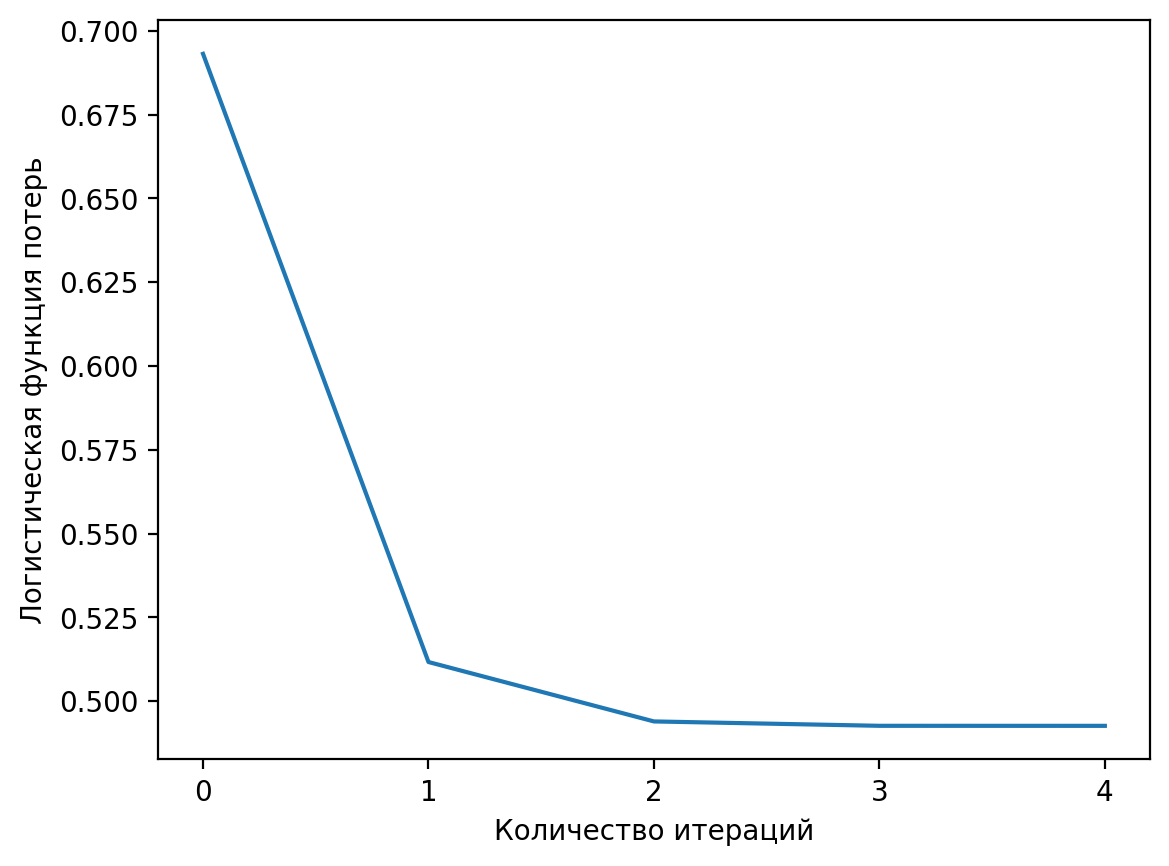

CPU times: user 865 ms, sys: 194 ms, total: 1.06 s
Wall time: 161 ms


In [31]:
%%time

# создаем экземпляр нашего класса LogisticRegression_Newton
model = LogisticRegression_Newton()
# обучаем модель логистической регрессии
model.fit(X_train, y_train)
# визуализируем кривую функции потерь
model.loss_visualize()

In [32]:
# вычислим AUC-ROC
proba = model.predict_proba(X_test)
print("AUC-ROC на тестовой выборке: %.3f" % roc_auc_score(y_test, proba))

AUC-ROC на тестовой выборке: 0.786
